In [1]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

In [2]:
# columns to exclude based on previous accessment. Including features with a single unique variable

columns_to_exclude = ['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'sessionId']

In [3]:
# load data with expanded json features

train_df = pd.read_csv('train_expanded.csv', low_memory=False, dtype={'fullVisitorId': 'str'})
train_df = train_df.drop(columns_to_exclude + ['trafficSource.campaignCode'], axis = 1)
# trafficSource.campaignCode not present in test data, so needs to be excluded from train too.

test_df = pd.read_csv('test_expanded.csv', low_memory=False, dtype={'fullVisitorId': 'str'})
test_df = test_df.drop(columns_to_exclude, axis = 1)

In [4]:
train_df.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,3,Organic Search,20160902,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,4,Organic Search,20160902,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google


In [5]:
test_df.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,0,Organic Search,20171016,6167871330617112363,1508151024,2,1508151024,Chrome,desktop,False,Macintosh,(not set),Asia,Singapore,(not set),myrepublic.com.sg,(not set),Southeast Asia,NaN,4,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,1,Organic Search,20171016,0643697640977915618,1508175522,1,1508175522,Chrome,desktop,False,Windows,Zaragoza,Europe,Spain,(not set),rima-tde.net,Aragon,Southern Europe,NaN,5,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,2,Organic Search,20171016,6059383810968229466,1508143220,1,1508143220,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,France,not available in demo dataset,sfr.net,not available in demo dataset,Western Europe,NaN,7,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,3,Organic Search,20171016,2376720078563423631,1508193530,1,1508193530,Safari,mobile,True,iOS,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,8,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,4,Organic Search,20171016,2314544520795440038,1508217442,1,1508217442,Safari,desktop,False,Macintosh,San Jose,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,9,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [6]:
# check the difference between columns of train and test data. only totals.transactionRevenue should be different
set(train_df.columns) - set(test_df.columns)

{'totals.transactionRevenue'}

In [7]:
# "visitStartTime" column contains the same information as "date", so it can be replaced
# i'll also generate features for the day of the week, hour, month and day of the month
train_df['date'] = pd.to_datetime(train_df['visitStartTime'], unit='s')
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['hour'] = train_df['date'].dt.hour
train_df['day_of_month'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month

test_df['date'] = pd.to_datetime(test_df['visitStartTime'], unit='s')
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['hour'] = test_df['date'].dt.hour
test_df['day_of_month'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month

# delete the "date" feature
train_df.drop('date', axis = 1, inplace = True)
test_df.drop('date', axis = 1, inplace = True)

In [18]:
train_df['visitNumber'][(train_df['totals.transactionRevenue'].isnull()) & (train_df['visitNumber'] > 1)]

4          2
45         3
46         2
63         5
67         2
69         2
87         2
116        2
127        2
132       11
136        2
142        2
143        2
144        3
146        4
147       57
154        3
155        6
158        2
161        6
169        3
171        2
185       56
188        2
192        2
199        7
201        2
206        2
223        3
227        4
          ..
903312     2
903316     3
903324     2
903335     2
903347     2
903416     2
903439     3
903442     2
903463     2
903482     2
903496     2
903505     6
903511     2
903513     2
903519    57
903521     2
903538     2
903541     2
903542     2
903543     3
903544     2
903566     2
903572     2
903591     2
903607     2
903608    11
903614     3
903622     2
903636     3
903643     4
Name: visitNumber, Length: 193543, dtype: int64

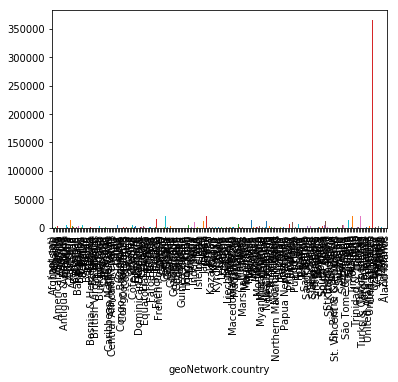

In [47]:
feature = 'geoNetwork.country'
agg_df = train_df[['fullVisitorId',feature]].groupby(feature).agg('count')
agg_df['fullVisitorId'].plot(kind='bar')

In [63]:
for col in cat_cols:
    print(col, train_df[col].nunique())

channelGrouping 8
device.browser 54
device.deviceCategory 3
device.operatingSystem 20
geoNetwork.city 649
geoNetwork.continent 6
geoNetwork.country 222
geoNetwork.metro 94
geoNetwork.networkDomain 28064
geoNetwork.region 376
geoNetwork.subContinent 23
trafficSource.adContent 45
trafficSource.adwordsClickInfo.adNetworkType 3
trafficSource.adwordsClickInfo.gclId 17775
trafficSource.adwordsClickInfo.page 9
trafficSource.adwordsClickInfo.slot 3
trafficSource.campaign 10
trafficSource.keyword 3660
trafficSource.medium 7
trafficSource.referralPath 1476
trafficSource.source 380
trafficSource.adwordsClickInfo.isVideoAd 2
trafficSource.isTrueDirect 2
day_of_week 7
hour 24
day_of_month 31
month 12


In [48]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect',
            'day_of_week', 'hour', 'day_of_month', 'month']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
        

# make sure that the numerical columns are float type
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)



channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
day_of_week
hour
day_of_month
month


In [56]:
for c in cat_cols:
    test_df[c] = test_df[c].astype('category')

In [57]:
from sklearn.model_selection import KFold

X_train_df = train_df[cat_cols + num_cols]
y_train_df = np.log1p(train_df["totals.transactionRevenue"].values)

X_test_df = test_df[cat_cols + num_cols]



# fitting without grid search, manual cross valudation
oof_reg_preds = np.zeros(train_df.shape[0])
sub_reg_preds = np.zeros(test_df.shape[0])

Num_Splits = 5

kfold = KFold(n_splits=Num_Splits)

for train_index, valid_index in kfold.split(X_train_df):
    print("TRAIN:", train_index, "TEST:", valid_index)
    X_train, X_valid = X_train_df.iloc[train_index], X_train_df.iloc[valid_index]
    y_train, y_valid = y_train_df[train_index], y_train_df[valid_index]
    
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_valid, label=y_valid)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    
    
    pred_test_y = model.predict(X_test_df, num_iteration=model.best_iteration)
    pred_val_y = model.predict(X_train_df, num_iteration=model.best_iteration)
    
    oof_reg_preds += pred_val_y / Num_Splits
    sub_reg_preds += pred_test_y / Num_Splits
    
    print('fold finished')

In [50]:
# Set params
params = {"objective" : "regression",
        "metric" : "rmse",
        'max_depth' : -1,
        'max_bin': 512,
        #"num_leaves" : 30,
        "min_child_samples" : 100,
        #"learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1}

# Create parameters to search
gridParams = {
    'learning_rate': [0.2, 0.15],
    'n_estimators': [70, 100],
    'num_leaves': [50, 75, 100],
    #'boosting_type' : ['gbdt'],
    #'objective' : ['binary'],
    #'random_state' : [501], # Updated from 'seed'
    'colsample_bytree': [0.3, 0.5],
    'subsample': [0.3, 0.5, 0.8],
    'reg_alpha': [1], #[1,1.2, 1.4],
    'reg_lambda': [1], #[1,1.2,1.4]
    }

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 60, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.3}
0.3373478625500481


In [51]:
# Create classifier to use. Note that parameters have to be input manually
# not as a dict!

mdl = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          feature_fraction = params['feature_fraction'],
          min_child_samples = params['min_child_samples'],
          bagging_fraction = params['bagging_fraction'],
          )

In [52]:
# To view the default model params:
mdl.get_params().keys()


dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'feature_fraction', 'bagging_fraction'])

In [53]:
# Create the grid search with 4 fold cross validation
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)

In [54]:
# Run the grid
grid.fit(X_train_df, y_train_df)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.3, 'learning_rate': 0.15, 'n_estimators': 70, 'num_leaves': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.3}
0.3358114593584676


In [58]:
# calculate prediction for test data
pred_test_y = grid.predict(X_test_df)

In [59]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0


In [60]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test_y[pred_test_y<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test_y)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [61]:
sub_df.shape

(617242, 2)